# FIGURE 3 PART 2 - VARIED Z 

## IMPORTS


In [41]:
try:
        
    import h5py
    
    from ipywidgets import widgets, Layout, interact, interactive, interactive_output, Dropdown
    from IPython.display import display
    import matplotlib.pyplot as mplt
    import numpy as np
    import random
    import seaborn as sns 
    import pandas as pd
    import graphing as gr
    #!pip install viola
    ########## Modules required for artist drawing on matplotlib
    import matplotlib.path as mpath
    import matplotlib.lines as mlines
    import matplotlib.patches as mpatches
    from matplotlib.collections import PatchCollection
    
      
except ModuleNotFoundError:
        print("A class you are trying to import is not present in the directory")
    
except Exception:
        print("Something went wrong - modules have not been imported")

else: 
    print("All relevant classes imported")
    

All relevant classes imported


In [42]:
#######################################################
#### GUI 

edt_filename = widgets.Text(description = 'File name', value='Exp3-8')
btn_select = widgets.Button(description = 'Select file',button_style='success')
output_file = widgets.Output()

display(edt_filename, btn_select,output_file)



#######################################################
#### FUNCTIONS


#df_flux = pd.DataFrame({'Compartment':[],'Na_net':[], 'Na_leak':[],'Na_Atpase':[], 'K_net':[],'K_leak':[],'K_Atpase':[],'K_kcc2':[], 'Cl_net':[],'Cl_kcc2':[],'X':[],'z':[]  })
df_ed = pd.DataFrame({'Boundary':[],'Na':[],'K':[],'Cl':[]})



def btn_select_clicked(b):
    global file_name, df_end, df_start, df_end_flux, df_end_ed, df_end_net_flux
    file_name = "\\"
    file_name = file_name + edt_filename.value 
    
    try: 
        with h5py.File(file_name, mode='r') as hdf:
            
            print("File found and content loaded into memory")
            global C, comp_names_arr, intervals, interval_arr, master_arr, t_arr, ED_master_arr,E_group_arr
            C = hdf.get('COMPARTMENTS')
            C_group_arr =[]
            t_arr_bool = True
            comp_names_arr= list(C.keys())
                        
            C1 = C.get(comp_names_arr[0])
            
            T = hdf.get('TIMING')
            total_t = T.get('TOTAL_T')[()]
            intervals = T.get('INTERVALS')[()]
            dt = T.get("DT")[()]
            total_steps = total_t /dt          
            interval_step = total_steps / intervals
            interval_arr = [round(interval_step * i) for i in range(intervals)]
            
            master_arr = []
            t_arr =[]
            
            
            
            
            ##### LOADING COMPARTMENT DATA
            for e in range(len(comp_names_arr)):
                C_group = C.get(comp_names_arr[e])
                C_group_arr.append(C_group)
               
                data_arr_2 =[]
                for j in range(len(list(C_group.keys()))):
                    dataset = C_group.get(str(interval_arr[j]))
                    
                    data_arr = []
                    for d in range(len(list(dataset))):
                        data_arr.append(dataset[d])
                    
                    data_arr_2.append(data_arr)
            
                    if t_arr_bool == True:
                        t_arr.append(data_arr[0])         
                
                master_arr.append(data_arr_2)
                t_arr_bool = False
                
            
            #df_start['radius'] = 
            
            E = hdf.get('ELECTRODIFFUSION')
            E_group_arr = list(E.keys())
            ED_master_arr = []            
            
            ##### LOADING ELECTRODIFFUSION DATA
            for x in range(len(E_group_arr)): # Looping through the electrodiffusion groups on the file
                
                E_group = E.get(E_group_arr[x])
                
                ED_data_arr =[] #stores the electrodiffusion data for a group
                
                for y in range(len(list(E_group.keys()))-1): # Looping through all the datasets of the group
                    
                    dataset = E_group.get(str(interval_arr[y+1]))
                   
                    ED_data_arr_2 = [] #stores the dataset values for one dataset
                    for z in range(len(list(dataset))): # Looping through the individual datasets to extract data
                        ED_data_arr_2.append(dataset[z])
                    
                    
                    ED_data_arr.append(ED_data_arr_2) 
                    
            
                ED_master_arr.append(ED_data_arr) #contains all the electrodiffusion data for all the groups (1st index is the group, 2nd index is the interval)
            
            
        ################
        # DATAFRAMES
        ################
    
        # START VALUE DATAFRAME
        df_start_data = [master_arr[i][0][1:9] for i in range(len(comp_names_arr))]
        df_start=pd.DataFrame(data=df_start_data, index=comp_names_arr)
        df_start.columns = ['Radius', 'Length', 'Volume', 'Na_i', 'K_i', 'Cl_i','X_i','z_i']
        
        # END VALUE DATAFRAME
        df_end_data = [master_arr[i][-1][1:9] for i in range(len(comp_names_arr))]
        for i in range(len(comp_names_arr)):
            df_end_data[i].append(master_arr[i][-1][-3]*1e3) #vm
            df_end_data[i].append(master_arr[i][-1][-2]*1e3) #ek
            df_end_data[i].append(master_arr[i][-1][-1]*1e3) #ecl
            df_end_data[i].append((master_arr[i][-1][-3]-master_arr[i][-1][-1])*1e3) #driving force
            
        df_end=pd.DataFrame(data=df_end_data,index=comp_names_arr)
        df_end.columns = ['Radius', 'Length', 'Volume', 'Na_i', 'K_i', 'Cl_i','X_i','z_i','Vm (mV)','Ek (mV)','ECl (mV)','Cl-Driving force (mV)']
        
        
        # END TRANSMEMBRANE FLUX DATAFRAME
        
        final_mol_data =  [master_arr[i][-1][9:19]  for i in range(len(comp_names_arr))]
        #semifinal_mol_data =  [master_arr[i][-2][9:19]  for i in range(len(comp_names_arr))]
        
        df_end_flux_data = []
        
    
        for i in range(len(final_mol_data)):
            temp_arr =[]
            for j in range(len(final_mol_data[i])):
                final_mol_data[i][j] = final_mol_data[i][j] * master_arr[i][-1][3]
                #semifinal_mol_data[i][j] = semifinal_mol_data[i][j] * master_arr[i][-2][3]
                #temp_arr.append(final_mol_data[i][j]-semifinal_mol_data[i][j])
            #df_end_flux_data.append(temp_arr)
            
            
        df_end_flux_cols = ['Na_net', 'Na_leak','Na_Atpase', 'K_net','K_leak','K_Atpase','K_kcc2', 'Cl_net','Cl_leak','Cl_kcc2']
        df_end_flux = pd.DataFrame(data =final_mol_data, index = comp_names_arr, columns=df_end_flux_cols)
        
        # END ELECTRODIFFUSION DATAFRAME
        df_end_ed_data = [ED_master_arr[i][-1][0:3] for i in range(len(ED_master_arr))]
        for i in range(len(df_end_ed_data)):
            for j in range(3):
                df_end_ed_data[i][j] = df_end_ed_data[i][j] * master_arr[i][-1][3]
                    
        
        df_end_ed_cols = ['Na_ED_flux', 'K_ED_flux', 'Cl_ED_flux']
        df_end_ed = pd.DataFrame(data = df_end_ed_data, index = E_group_arr, columns=df_end_ed_cols)
        
        
        
        # NET FLUX DATAFRAME
        na_net_arr, k_net_arr,cl_net_arr,x_net_arr,total_net_arr = [],[],[],[],[]
       
        for i in range(len(comp_names_arr)):
            na_net_arr.append(df_end_flux.iloc[i][0])
            k_net_arr.append(df_end_flux.iloc[i][3])
            cl_net_arr.append(df_end_flux.iloc[i][7])

        x_net_arr = [((master_arr[i][-1][7] * master_arr[i][-1][3]) -(master_arr[i][-2][7] * master_arr[i][-2][3]))  for i in range(len(comp_names_arr))]
        #(master_arr[i][-2][7]- master_arr[i][-2][3]
        
        for j in range(len(E_group_arr)):
            na_net_arr[j] = na_net_arr[j] - df_end_ed.iloc[j][0]
            na_net_arr[j+1] = na_net_arr[j+1] + df_end_ed.iloc[j][0]
            k_net_arr[j] = k_net_arr[j] - df_end_ed.iloc[j][1]
            k_net_arr[j+1] = k_net_arr[j+1] + df_end_ed.iloc[j][1]
            cl_net_arr[j] = cl_net_arr[j] + df_end_ed.iloc[j][2]
            cl_net_arr[j+1] = cl_net_arr[j+1] - df_end_ed.iloc[j][2]

        total_net_arr = [na_net_arr[a]+k_net_arr[a]-cl_net_arr[a]-x_net_arr[a] for a in range(len(comp_names_arr))]


        df_end_net_flux = pd.DataFrame(data ={'Na-Net':na_net_arr, 'K-Net':k_net_arr,'Cl-Net':cl_net_arr,'X-Net':x_net_arr,'Total':total_net_arr }, index=comp_names_arr)     


            
    except: 
        raise("File not found")
        raise("File needs to be in base directory")


btn_select.on_click(btn_select_clicked)

Text(value='Exp3-8', description='File name')

Button(button_style='success', description='Select file', style=ButtonStyle())

Output()

## BASIC Z CHANGE DESCRIPTIONS 

Button(button_style='info', description='Plot 3A', style=ButtonStyle())

Output()

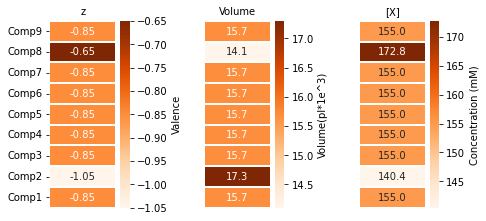

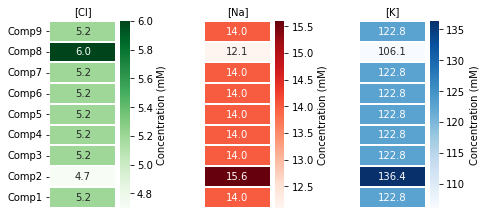

In [21]:
########################################
# GUI
########################################

btn_f3a = widgets.Button(description="Plot 3A", button_style='info')
output_f3a = widgets.Output()

display(btn_f3a, output_f3a)



########################################
# BACKEND
########################################
def btn_f3a_clicked(b):

    f3a_1, [ax_z,ax_vol,ax_x] = mplt.subplots(1,3,figsize=(7,4))
    f3a_1.tight_layout(pad=4)
    f3a_2, [ax_cl,ax_na,ax_k] = mplt.subplots(1,3,figsize=(7,4))
    f3a_2.tight_layout(pad=4)
    
    z_arr,vol_arr,x_arr = [], [], []
    cl_arr,na_arr,k_arr = [],[],[] 

    
    
    
    for i in range(len(master_arr)):
        z_arr.append([master_arr[i][-1][8]])
        vol_arr.append([round(master_arr[i][-1][3]*1e15,1)])
        x_arr.append([round(master_arr[i][-1][7]*1e3,1)])
        
        cl_arr.append([round(master_arr[i][-1][6]*1e3,1)])
        na_arr.append([round(master_arr[i][-1][4]*1e3,1)])
        k_arr.append([round(master_arr[i][-1][5]*1e3,1)])
    
    g = sns.heatmap(z_arr,cmap="Oranges", annot=True,fmt='', xticklabels=False,
                    cbar_kws={'pad':0.05,'label':'Valence', 'orientation':'vertical' }, ax=ax_z,linewidth=0.01 )
    g.set_yticklabels(comp_names_arr[::-1], fontsize=10, rotation=0)
    ax_z.set_title("z",fontsize=10)
    
    g = sns.heatmap(vol_arr,cmap="Oranges", annot=True,fmt='', yticklabels =False, xticklabels=False,
                    cbar_kws={'pad':0.05,'label':'Volume(pl*1e^3)', 'orientation':'vertical' }, ax=ax_vol,linewidth=0.01 )

    ax_vol.set_title("Volume",fontsize=10)
    
    g = sns.heatmap(x_arr,cmap="Oranges", annot=True,fmt='', yticklabels = False, xticklabels=False,
                    cbar_kws={'pad':0.05,'label':'Concentration (mM)','orientation':'vertical' }, ax=ax_x,linewidth=0.01 )
    ax_x.set_title("[X]",fontsize=10)
    
    
    
    g = sns.heatmap(cl_arr,cmap="Greens", annot=True,fmt='', xticklabels=False,
                    cbar_kws={'pad':0.05,'label':'Concentration (mM)', 'orientation':'vertical' }, ax=ax_cl,linewidth=0.01 )
    g.set_yticklabels(comp_names_arr[::-1], fontsize=10, rotation=0)
    ax_cl.set_title("[Cl]",fontsize=10)
    
    g = sns.heatmap(na_arr,cmap="Reds", annot=True,fmt='', yticklabels =False, xticklabels=False,
                    cbar_kws={'pad':0.05,'label':'Concentration (mM)', 'orientation':'vertical' }, ax=ax_na,linewidth=0.01 )
    ax_na.set_title("[Na]",fontsize=10)
    
    g = sns.heatmap(k_arr,cmap="Blues", annot=True,fmt='', yticklabels = False, xticklabels=False,
                    cbar_kws={'pad':0.05,'label':'Concentration (mM)','orientation':'vertical' }, ax=ax_k,linewidth=0.01 )
    ax_k.set_title("[K]",fontsize=10)
    
########################################
# IMPLEMENTATION
########################################
btn_f3a.on_click(btn_f3a_clicked)

## Voltages across compartments

Button(button_style='info', description='Plot 3B', style=ButtonStyle())

Output()

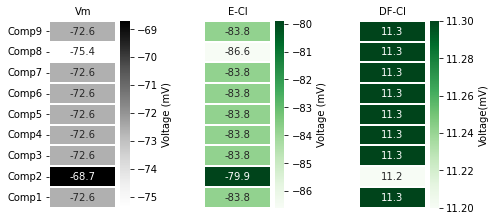

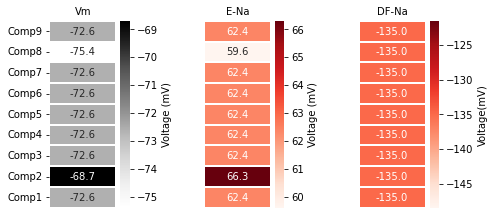

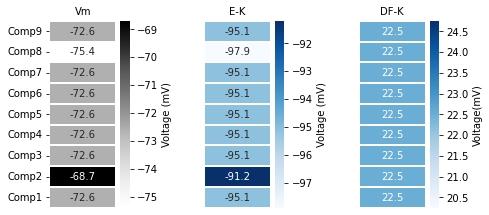

In [36]:
########################################
# GUI
########################################

btn_f3b = widgets.Button(description="Plot 3B", button_style='info')
output_f3b = widgets.Output()

display(btn_f3b, output_f3b)



########################################
# BACKEND
########################################

R = 8.31446
F: float = 96485.33  # Faraday's constant        C mol-1
T = 37 + 273.15
RTF = R * T / F
    

def btn_f3b_clicked(b):

    f3b_1, [ax_vm1,ax_ecl,ax_dfcl] = mplt.subplots(1,3,figsize=(7,4))
    f3b_1.tight_layout(pad=4)
    
    f3b_2, [ax_vm2,ax_ena,ax_dfna] = mplt.subplots(1,3,figsize=(7,4))
    f3b_2.tight_layout(pad=4)
    
    f3b_3, [ax_vm3,ax_ek,ax_dfk] = mplt.subplots(1,3,figsize=(7,4))
    f3b_3.tight_layout(pad=4)
    
    vm_arr,ecl_arr,ek_arr,ena_arr = [], [], [],[]
    dfcl_arr,dfna_arr,dfk_arr = [],[],[] 

    
    for i in range(len(master_arr)):
     
        vm_arr.append([round(master_arr[i][-1][-3]*1e3,1)])
        ecl_arr.append([round(master_arr[i][-1][-1]*1e3,1)])
        ena_arr.append([round((-1*RTF * np.log(master_arr[i][-1][4]/145e-3)*1e3),1)])
        ek_arr.append([round(master_arr[i][-1][-2]*1e3,1)])
        
        dfcl_arr.append([round((master_arr[i][-1][-3]*1e3) - (master_arr[i][-1][-1]*1e3),1) ])
        dfna_arr.append([round((master_arr[i][-1][-3] - (-1*RTF * np.log(master_arr[i][-1][4]/145e-3)))*1e3,1) ])
        dfk_arr.append([round(master_arr[i][-1][-3]*1e3 - master_arr[i][-1][-2]*1e3,1) ])
        
    vm_arr.reverse()
    ecl_arr.reverse()
    ena_arr.reverse()
    ek_arr.reverse()
    dfcl_arr.reverse()
    dfna_arr.reverse()
    dfk_arr.reverse()
    ############
    # Cl graphs
    ############
    
    
    g = sns.heatmap(vm_arr,cmap="Greys", annot=True,fmt='', yticklabels =True, xticklabels=False,
                    cbar_kws={'pad':0.05,'label':'Voltage (mV)', 'orientation':'vertical' }, ax=ax_vm1,linewidth=0.01 )
    g.set_yticklabels(comp_names_arr[::-1], fontsize=10, rotation=0)
    ax_vm1.set_title("Vm",fontsize=10)
    
    g = sns.heatmap(ecl_arr,cmap="Greens", annot=True,fmt='', yticklabels = False,xticklabels=False,
                    cbar_kws={'pad':0.05,'label':'Voltage (mV)','orientation':'vertical' }, ax=ax_ecl,linewidth=0.01 )
    ax_ecl.set_title("E-Cl",fontsize=10)
    
     
    g = sns.heatmap(dfcl_arr,cmap="Greens", annot = True,fmt='', yticklabels = False, xticklabels=False,
                    cbar_kws={'pad':0.05,'label':'Voltage(mV)', 'orientation':'vertical' }, ax=ax_dfcl,linewidth=0.01 )
    ax_dfcl.set_title("DF-Cl",fontsize=10)
    
    ##################
    # Na graphs
    ##################
    
    g = sns.heatmap(vm_arr,cmap="Greys", annot=True,fmt='', yticklabels =True, xticklabels=False,
                    cbar_kws={'pad':0.05,'label':'Voltage (mV)', 'orientation':'vertical' }, ax=ax_vm2,linewidth=0.01 )
    g.set_yticklabels(comp_names_arr[::-1], fontsize=10, rotation=0)
    ax_vm2.set_title("Vm",fontsize=10)
    
    g = sns.heatmap(ena_arr,cmap="Reds", annot=True,fmt='', yticklabels = False,xticklabels=False,
                    cbar_kws={'pad':0.05,'label':'Voltage (mV)','orientation':'vertical' }, ax=ax_ena,linewidth=0.01 )
    ax_ena.set_title("E-Na",fontsize=10)
    
     
    g = sns.heatmap(dfna_arr,cmap="Reds", annot = True,fmt='', yticklabels = False,xticklabels=False,
                    cbar_kws={'pad':0.05,'label':'Voltage(mV)', 'orientation':'vertical' }, ax=ax_dfna,linewidth=0.01 )
    ax_dfna.set_title("DF-Na",fontsize=10)
    
    #################
    # K graphs
    #################
    
    g = sns.heatmap(vm_arr,cmap="Greys", annot=True,fmt='', yticklabels =True, xticklabels=False,
                    cbar_kws={'pad':0.05,'label':'Voltage (mV)', 'orientation':'vertical' }, ax=ax_vm3,linewidth=0.01 )
    g.set_yticklabels(comp_names_arr[::-1], fontsize=10, rotation=0)
    ax_vm3.set_title("Vm",fontsize=10)
    
    g = sns.heatmap(ek_arr,cmap="Blues", annot=True,fmt='', yticklabels = False, xticklabels=False,
                    cbar_kws={'pad':0.05,'label':'Voltage (mV)','orientation':'vertical' }, ax=ax_ek,linewidth=0.01 )
    ax_ek.set_title("E-K",fontsize=10)
    
     
    g = sns.heatmap(dfk_arr,cmap="Blues", annot = True,fmt='', yticklabels = False, xticklabels=False,
                    cbar_kws={'pad':0.05,'label':'Voltage(mV)', 'orientation':'vertical' }, ax=ax_dfk,linewidth=0.01 )
    ax_dfk.set_title("DF-K",fontsize=10)

    
########################################
# IMPLEMENTATION
########################################
btn_f3b.on_click(btn_f3b_clicked)

## Boundary graphs

Button(button_style='info', description='Plot 3C', style=ButtonStyle())

Output()

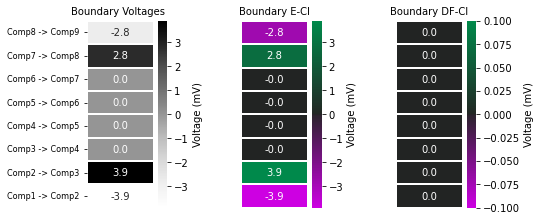

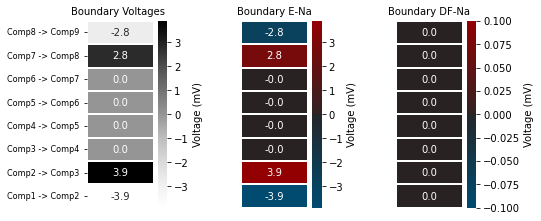

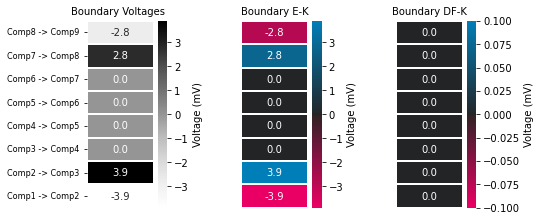

In [40]:
########################################
# GUI
########################################

btn_f3c = widgets.Button(description="Plot 3C", button_style='info')
output_f3c = widgets.Output()

display(btn_f3c, output_f3c)

########################################
# BACKEND
########################################

def btn_f3c_clicked(b):
        
    global RTF
    R = 8.31446
    F = 96485.33  # Faraday's constant        C mol-1
    T = 37 + 273.15
    RTF = R * T / F

    
    f3c_cl, [ax_vb1,ax_b_ecl,ax_b_dfcl] = mplt.subplots(1,3, figsize=(7,4))
    f3c_na,[ax_vb2,ax_b_ena,ax_b_dfna] = mplt.subplots(1,3, figsize=(7,4))
    f3c_k,[ax_vb3,ax_b_ek,ax_b_dfk]  = mplt.subplots(1,3,figsize=(7,4))
    
    f3c_cl.tight_layout(pad=4)
    f3c_na.tight_layout(pad=4)
    f3c_k.tight_layout(pad=4)
    
    cl_cmap = sns.diverging_palette(300, 140,l=50,s=100, center='dark', as_cmap=True)
    na_cmap = sns.diverging_palette(240, 12,l=30,s=100, center='dark', as_cmap=True) 
    k_cmap = sns.diverging_palette(360, 240,l=50,s=100, center='dark', as_cmap=True)
    
    cl_bdf_arr, na_bdf_arr, k_bdf_arr = [],[],[]
    vb_arr = []
    b_ecl_arr,b_ena_arr,b_ek_arr = [],[],[]
    b_dfcl_arr,b_dfna_arr,b_dfk_arr = [],[],[]
    
    

    for i in range(0,len(ED_master_arr)):

        vb = round((master_arr[i][-1][-3] - master_arr[i+1][-1][-3]) *1e3,1)
        vb_arr.append([vb])
        b_ecl = round((-RTF * np.log(master_arr[i+1][-1][6] / master_arr[i][-1][6]))*1e3,1)
        b_ecl_arr.append([b_ecl])
        b_ena = round((RTF * np.log(master_arr[i+1][-1][4] / master_arr[i][-1][4]))*1e3,1)
        b_ena_arr.append([b_ena])
        b_ek = round((RTF * np.log(master_arr[i+1][-1][5] / master_arr[i][-1][5]))*1e3,1)
        b_ek_arr.append([b_ek])
        b_dfcl_arr.append([round(vb-b_ecl,1)])
        b_dfna_arr.append([round(vb-b_ena,1)])
        b_dfk_arr.append([round(vb-b_ek,1)])

        """
        ecl_bound = [RTF * np.log(master_arr[i-1][j][6] / master_arr[i][j][6]) for j in range(len(t_arr))]
        temp_bdf = [(v_bound[j] - ecl_bound[j])*1e3 for j in range(len(v_bound))]
        temp_bdf = temp_bdf[:25000:1000]
        cl_bdf_arr.append(temp_bdf)
        
        ena_bound = [RTF * np.log(master_arr[i-1][j][4] / master_arr[i][j][4]) for j in range(len(t_arr))]
        temp_bdf = [(v_bound[j] - ena_bound[j])*1e3 for j in range(len(v_bound))]
        temp_bdf = temp_bdf[:25000:1000]
        na_bdf_arr.append(temp_bdf)
        
        ek_bound = [RTF * np.log(master_arr[i-1][j][5] / master_arr[i][j][5]) for j in range(len(t_arr))]
        temp_bdf = [(v_bound[j] - ena_bound[j])*1e3 for j in range(len(v_bound))]
        temp_bdf = temp_bdf[:25000:1000]
        k_bdf_arr.append(temp_bdf)
        """

    vb_arr.reverse()
    b_ecl_arr.reverse()
    b_ena_arr.reverse()
    b_ek_arr.reverse()
    b_dfcl_arr.reverse()
    b_dfna_arr.reverse()
    b_dfk_arr.reverse()
  
    bound_names_arr = [comp_names_arr[i] + ' -> ' + comp_names_arr[i+1] for i in range(len(comp_names_arr)-1)]
  
    g = sns.heatmap(vb_arr,cmap="Greys",annot=True,xticklabels=False,  fmt='',cbar_kws={'pad':0.05,'label':'Voltage (mV)', 'orientation':'vertical' }, ax=ax_vb1,linewidth=0.01 )
    g.set_yticklabels(bound_names_arr[::-1], fontsize=8, rotation=0)
    ax_vb1.set_title("Boundary Voltages ",fontsize=10)
    
    g = sns.heatmap(b_ecl_arr,cmap=cl_cmap,annot=True,xticklabels=False,fmt='', yticklabels=False,  cbar_kws={'pad':0.05,'label':'Voltage (mV)', 'orientation':'vertical' }, ax=ax_b_ecl,linewidth=0.01 )
    ax_b_ecl.set_title("Boundary E-Cl",fontsize=10)

    g = sns.heatmap(b_dfcl_arr,cmap=cl_cmap,annot=True,xticklabels=False,fmt='', yticklabels=False,  cbar_kws={'pad':0.05,'label':'Voltage (mV)', 'orientation':'vertical' }, ax=ax_b_dfcl,linewidth=0.01 )
    ax_b_dfcl.set_title("Boundary DF-Cl",fontsize=10)
    
    g = sns.heatmap(vb_arr,cmap="Greys",annot=True,xticklabels=False,fmt='',  cbar_kws={'pad':0.05,'label':'Voltage (mV)', 'orientation':'vertical' }, ax=ax_vb2,linewidth=0.01 )
    g.set_yticklabels(bound_names_arr[::-1], fontsize=8, rotation=0)
    ax_vb2.set_title("Boundary Voltages ",fontsize=10)

    
    g = sns.heatmap(b_ena_arr,cmap=na_cmap,annot=True,xticklabels=False,fmt='', yticklabels=False,  cbar_kws={'pad':0.05,'label':'Voltage (mV)', 'orientation':'vertical' }, ax=ax_b_ena,linewidth=0.01 )
    ax_b_ena.set_title("Boundary E-Na",fontsize=10)

    g = sns.heatmap(b_dfna_arr,cmap=na_cmap,annot=True,xticklabels=False,fmt='', yticklabels=False,  cbar_kws={'pad':0.05,'label':'Voltage (mV)', 'orientation':'vertical' }, ax=ax_b_dfna,linewidth=0.01 )
    ax_b_dfna.set_title("Boundary DF-Na",fontsize=10)
    
    g = sns.heatmap(vb_arr,cmap="Greys",annot=True,xticklabels=False, fmt='', cbar_kws={'pad':0.05,'label':'Voltage (mV)', 'orientation':'vertical' }, ax=ax_vb3,linewidth=0.01 )
    g.set_yticklabels(bound_names_arr[::-1], fontsize=8, rotation=0)
    ax_vb3.set_title("Boundary Voltages ",fontsize=10)

    g = sns.heatmap(b_ek_arr,cmap=k_cmap,annot=True,xticklabels=False,fmt='', yticklabels=False,  cbar_kws={'pad':0.05,'label':'Voltage (mV)', 'orientation':'vertical' }, ax=ax_b_ek,linewidth=0.01 )
    ax_b_ek.set_title("Boundary E-K",fontsize=10)

    g = sns.heatmap(b_dfk_arr,cmap=k_cmap,annot=True,xticklabels=False, fmt='',yticklabels=False,  cbar_kws={'pad':0.05,'label':'Voltage (mV)', 'orientation':'vertical' }, ax=ax_b_dfk,linewidth=0.01 )
    ax_b_dfk.set_title("Boundary DF-K",fontsize=10)

    

btn_f3c.on_click(btn_f3c_clicked)


Button(button_style='info', description='Plot 3B', style=ButtonStyle())

Output()

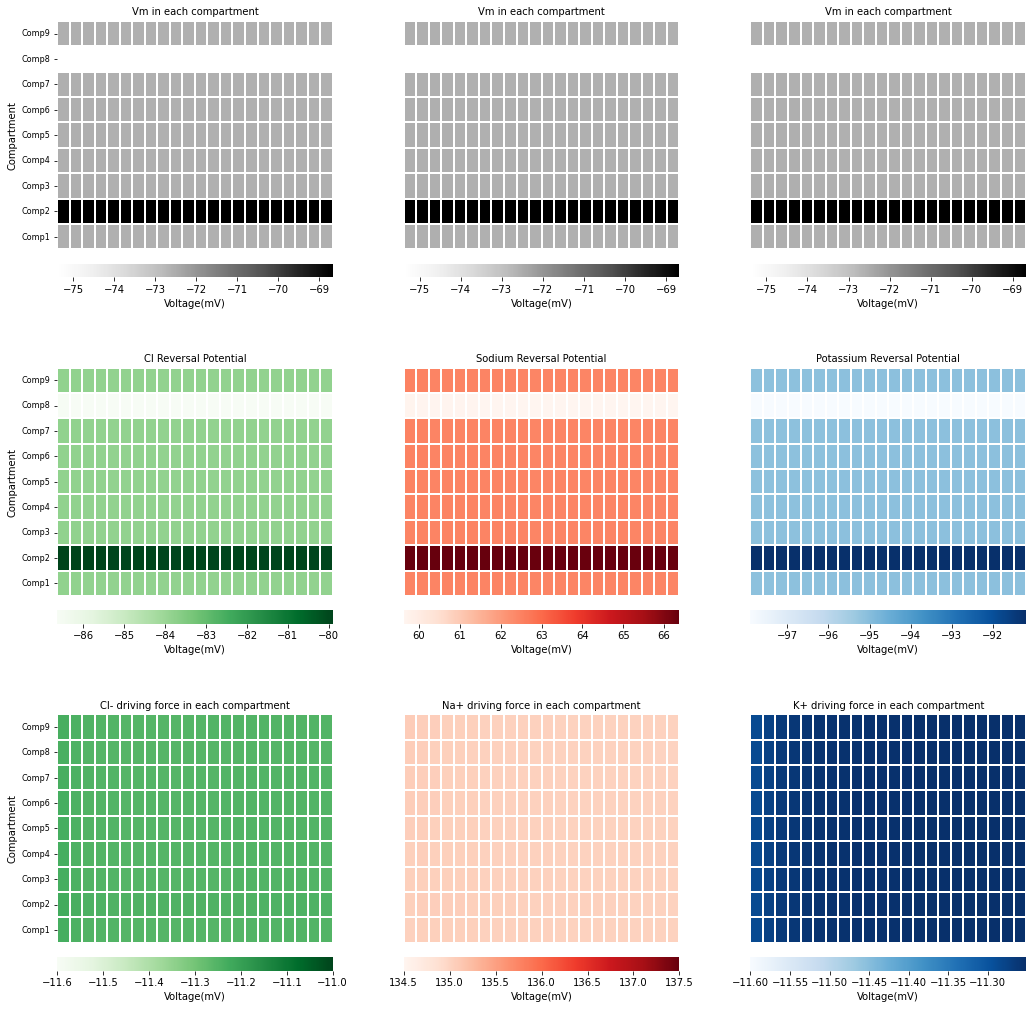

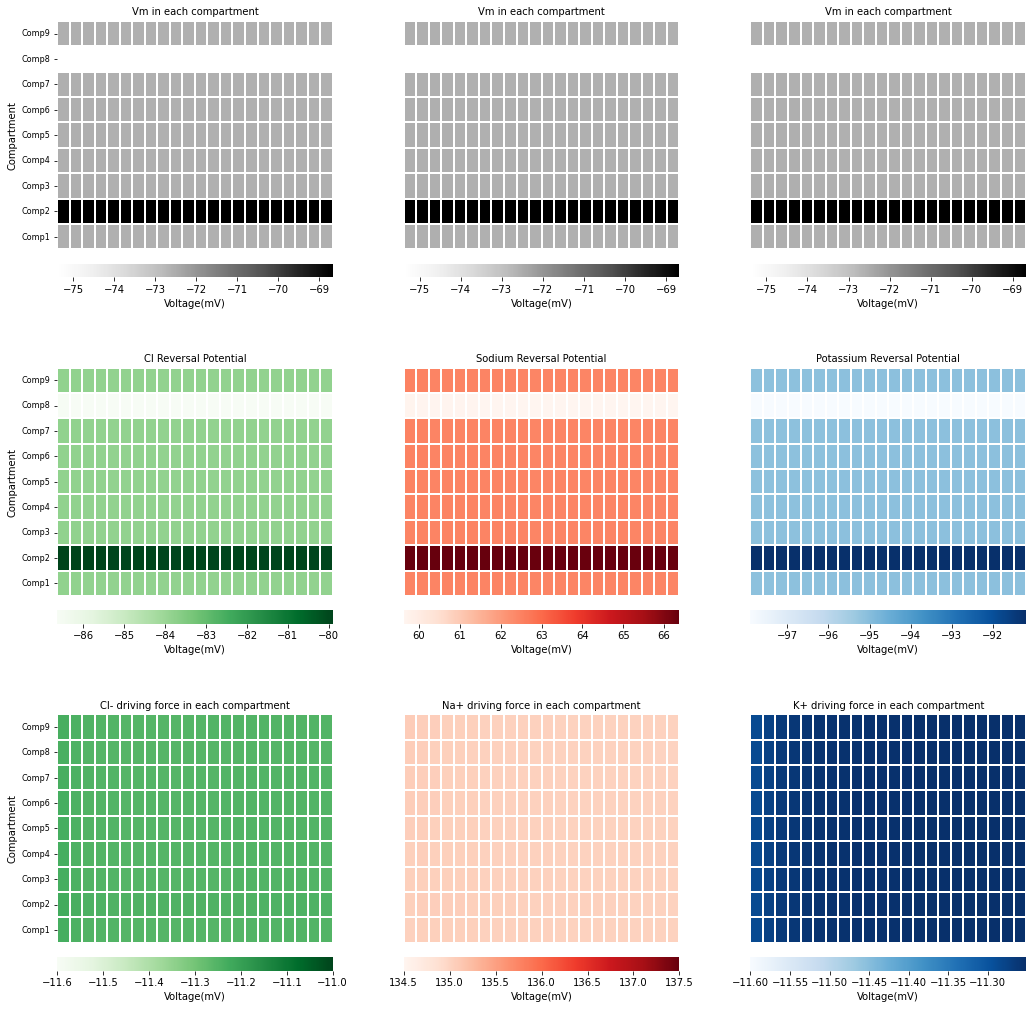

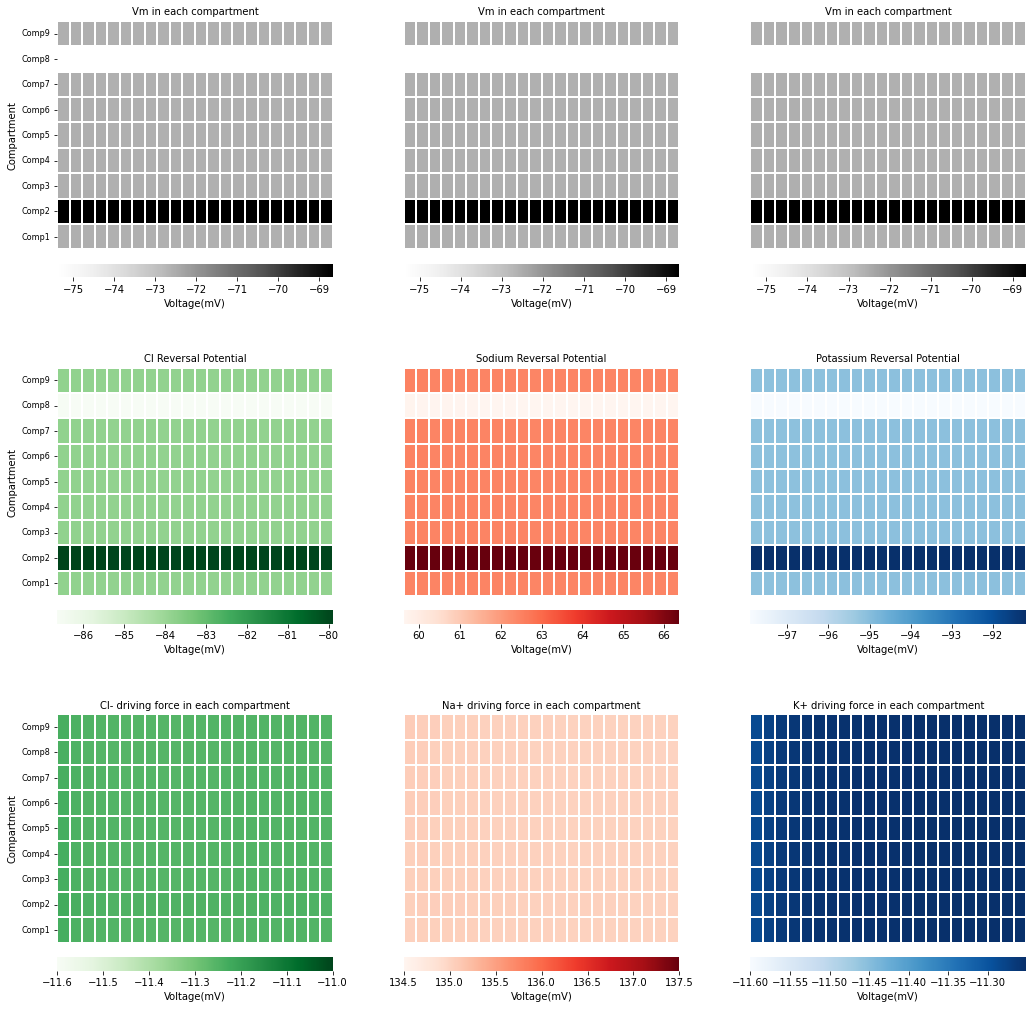

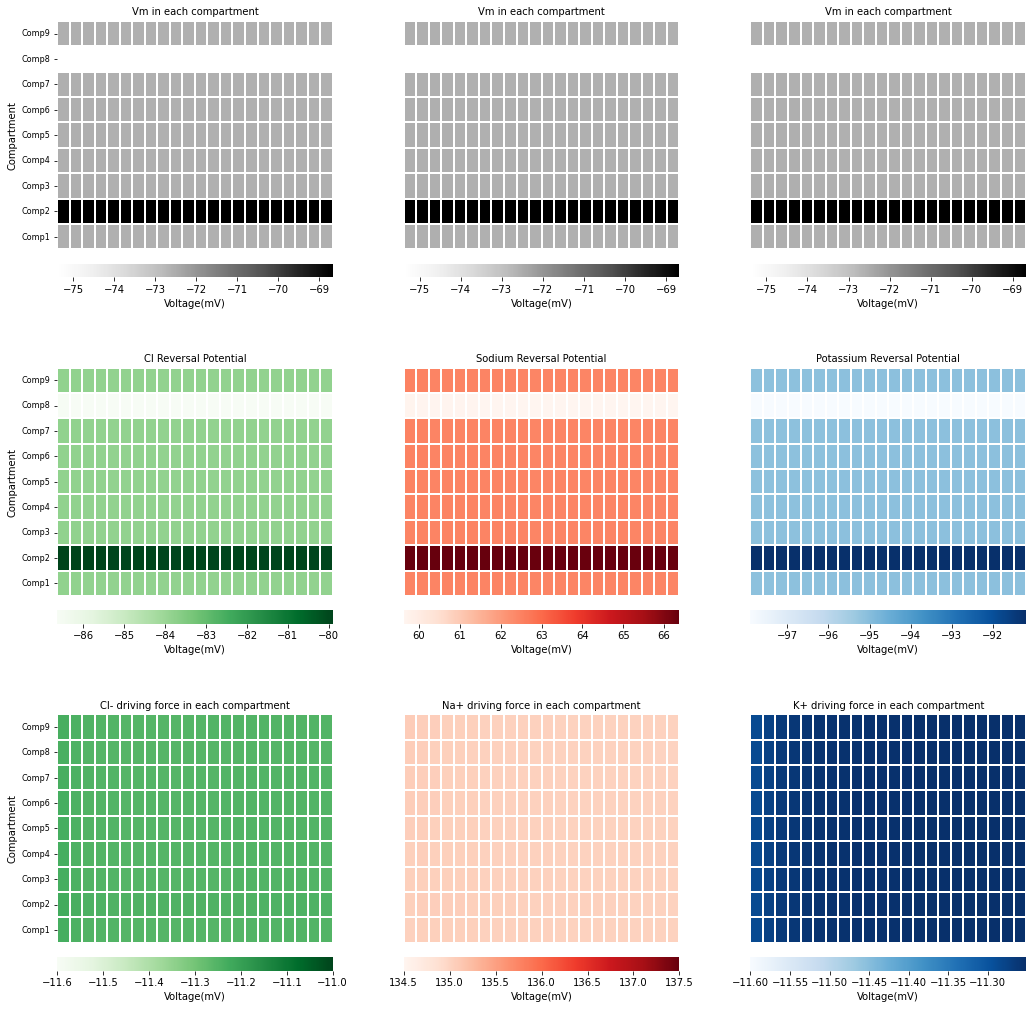

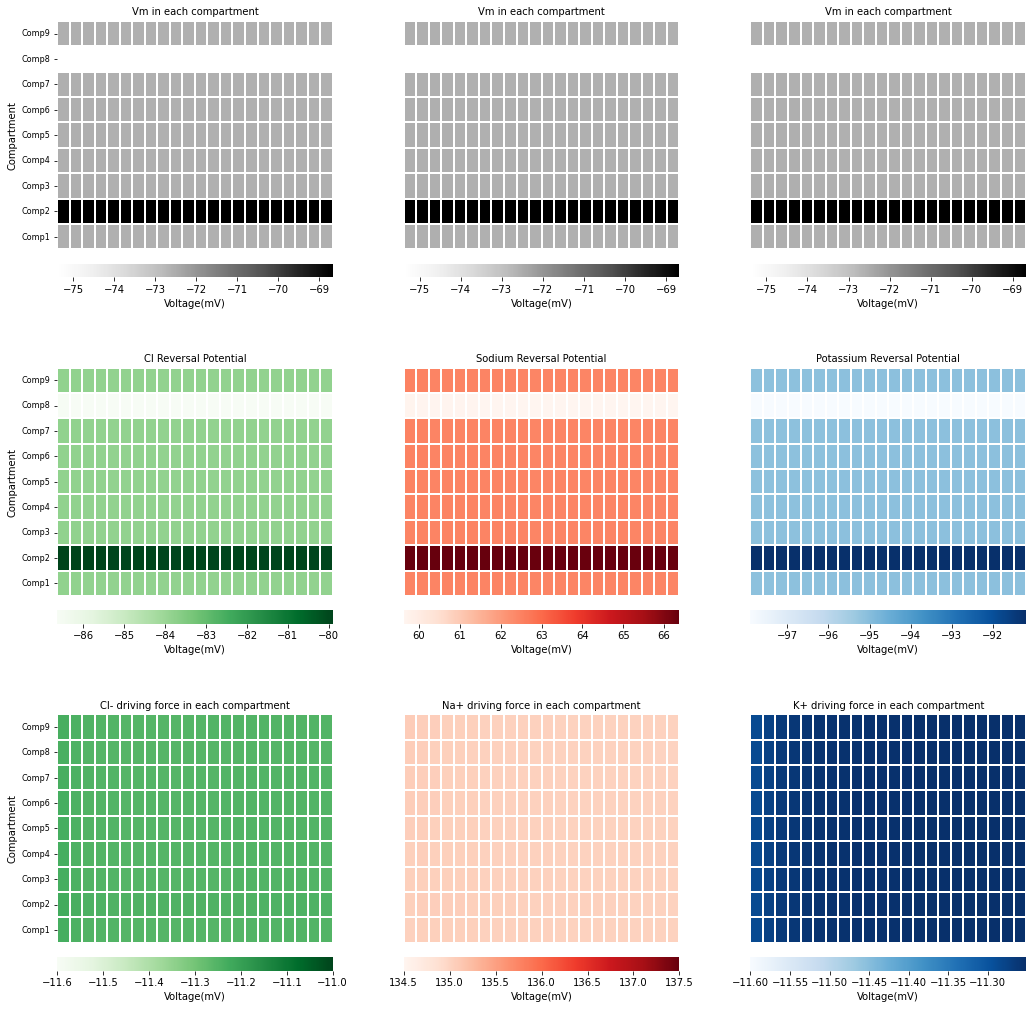

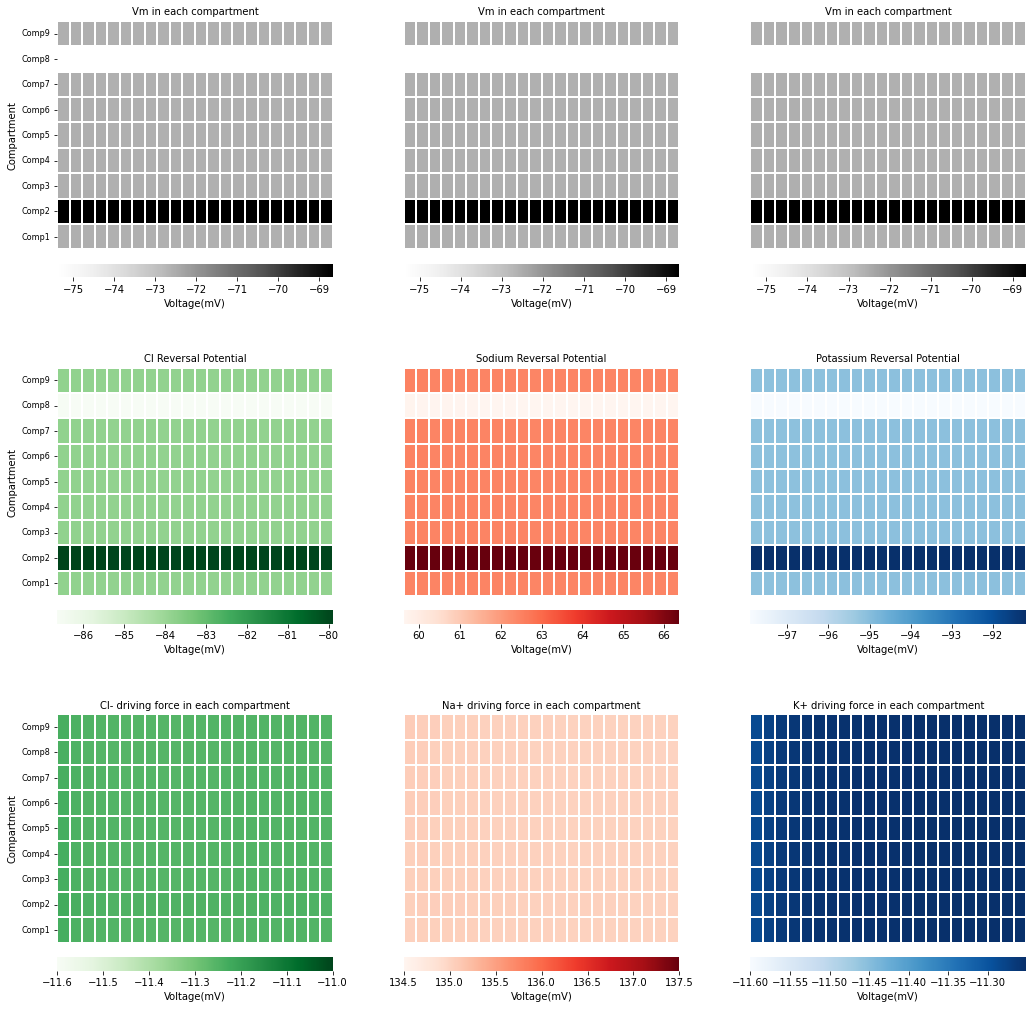

In [4]:
########################################
# GUI
########################################

btn_f3b = widgets.Button(description="Plot 3B", button_style='info')
output_f3b = widgets.Output()

display(btn_f3b, output_f3b)



########################################
# BACKEND
########################################

def btn_f3b_clicked(b):

    f3b, [(left_ax_vm,mid_ax_vm,right_ax_vm),(left_ax_ecl, mid_ax_ena, right_ax_ek), 
          (left_ax_dfcl, mid_ax_dfna, right_ax_dfk)] = mplt.subplots(3,3, figsize=(15,15))
    f3b.tight_layout(pad=4.0)
    
    R = 8.31446
    F: float = 96485.33  # Faraday's constant        C mol-1
    T = 37 + 273.15
    RTF = R * T / F
    
    x_arr = [round(t_arr[i]) for i in range(len(t_arr))]
    
    
    

    
    
    ####### HEAT MAPS
    
    vm_arr = []
    ecl_arr_heatmap, ena_arr_heatmap, ek_arr_heatmap = [],[],[]
    cldf_arr, nadf_arr, kdf_arr = [],[],[]
    
    for i in range(len(comp_names_arr),0,-1):
        
        temp_arr_vm = [master_arr[i-1][j][-3]*1e3 for j in range(len(master_arr[0]))] 
        temp_arr_vm = temp_arr_vm[120::40]
        vm_arr.append(temp_arr_vm)
        
        ###########
        ecl_arr =[ master_arr[i-1][j][-1]*1e3 for j in range(len(master_arr[8]))]
        temp_arr_cl = ecl_arr[120::40]
        ecl_arr_heatmap.append(temp_arr_cl)
        
        ena_arr =[ (-1*RTF * np.log(master_arr[i-1][j][4]/145e-3))*1e3 for j in range(len(master_arr[8]))]
        temp_arr_mid = ena_arr[120::40]
        ena_arr_heatmap.append(temp_arr_mid)
        
        ek_arr = [ master_arr[i-1][j][-2]*1e3 for j in range(len(master_arr[8])) ]
        temp_arr_right = ek_arr[120::40]
        ek_arr_heatmap.append(temp_arr_right)
        
        ###########
        temp_arr_df= [master_arr[i-1][j][-1]*1e3 - master_arr[i-1][j][-3]*1e3 for j in range(len(master_arr[0]))] 
        temp_arr_cl2 = temp_arr_df[120::40]
        cldf_arr.append(temp_arr_cl2)
        
        temp_arr_df= [(-1*RTF * np.log(master_arr[i-1][j][4]/145e-3))*1e3 - master_arr[i-1][j][-3]*1e3 for j in range(len(master_arr[0]))] 
        temp_arr_na2 = temp_arr_df[120::40]
        nadf_arr.append(temp_arr_na2)
        
        temp_arr_df = [master_arr[i-1][j][-2]*1e3 - master_arr[i-1][j][-1]*1e3 for j in range(len(master_arr[0]))] 
        temp_arr_k2 = temp_arr_df[120::40]
        kdf_arr.append(temp_arr_k2)
        
        
    
    ####################
    grey_heatmap = sns.cubehelix_palette(50, hue=0.05, rot=0, light=0.9, dark=0, as_cmap=True)
    
    g_vm_left = sns.heatmap(vm_arr,cmap="Greys",xticklabels=False,  cbar_kws={'pad':0.05,'label':'Voltage(mV)', 'orientation':'horizontal' }, ax=left_ax_vm,linewidth=0.01 )
    g_vm_left.set_ylabel("Compartment",fontsize=10)
    g_vm_left.set_yticklabels(comp_names_arr[::-1], fontsize=8, rotation=0)
    left_ax_vm.set_title("Vm in each compartment",fontsize=10)    
        
    g_vm_mid = sns.heatmap(vm_arr,cmap="Greys",xticklabels=False, yticklabels=False,  cbar_kws={'pad':0.05,'label':'Voltage(mV)', 'orientation':'horizontal' }, ax=mid_ax_vm,linewidth=0.01 )
    #g_vm_mid.set_ylabel("Compartment",fontsize=10)
    #g_vm_mid.set_yticklabels(comp_names_arr[-1:0:-1], fontsize=8, rotation=0)
    mid_ax_vm.set_title("Vm in each compartment",fontsize=10)  
    
    g_vm_right = sns.heatmap(vm_arr,cmap="Greys",xticklabels=False, yticklabels=False, cbar_kws={'pad':0.05,'label':'Voltage(mV)', 'orientation':'horizontal' }, ax=right_ax_vm,linewidth=0.01 )
    #g_vm_right.set_ylabel("Compartment",fontsize=10)
    #g_vm_right.set_yticklabels(comp_names_arr[-1:0:-1], fontsize=8, rotation=0)
    right_ax_vm.set_title("Vm in each compartment",fontsize=10)  
    ######################
    g_ecl_left = sns.heatmap(ecl_arr_heatmap,cmap="Greens",xticklabels=False,  cbar_kws={'pad':0.05,'label':'Voltage(mV)', 'orientation':'horizontal' }, ax=left_ax_ecl,linewidth=0.01 )
    g_ecl_left.set_ylabel("Compartment",fontsize=10)
    g_ecl_left.set_yticklabels(comp_names_arr[::-1], fontsize=8, rotation=0)
    left_ax_ecl.set_title("Cl Reversal Potential",fontsize=10)
    
    g_ena_mid = sns.heatmap(ena_arr_heatmap,cmap="Reds",xticklabels=False, yticklabels=False, cbar_kws={'pad':0.05,'label':'Voltage(mV)', 'orientation':'horizontal' }, ax=mid_ax_ena,linewidth=0.01 )
    #g_ena_mid.set_ylabel("Compartment",fontsize=10)
    #g_ena_mid.set_yticklabels(comp_names_arr[-1:0:-1], fontsize=8, rotation=0)
    mid_ax_ena.set_title("Sodium Reversal Potential",fontsize=10)
    
    g_ek_right = sns.heatmap(ek_arr_heatmap,cmap="Blues",xticklabels=False, yticklabels=False, cbar_kws={'pad':0.05,'label':'Voltage(mV)', 'orientation':'horizontal' }, ax=right_ax_ek,linewidth=0.01 )
    #g_ek_right.set_ylabel("Compartment",fontsize=10)
    #g_ek_right.set_yticklabels(comp_names_arr[-1:0:-1], fontsize=8, rotation=0)
    right_ax_ek.set_title("Potassium Reversal Potential",fontsize=10)
    ########################
    
    g_cldf = sns.heatmap(cldf_arr,cmap="Greens",xticklabels=False, vmin=-11, vmax= -11.6, cbar_kws={'pad':0.05,'label':'Voltage(mV)', 'orientation':'horizontal' }, ax=left_ax_dfcl,linewidth=0.01 )
    g_cldf.set_ylabel("Compartment",fontsize=10)
    g_cldf.set_yticklabels(comp_names_arr[::-1], fontsize=8, rotation=0)
    left_ax_dfcl.set_title("Cl- driving force in each compartment",fontsize=10)
    
    g_nadf = sns.heatmap(nadf_arr,cmap="Reds",xticklabels=False, vmin = 134.5, vmax= 137.5, yticklabels=False, cbar_kws={'pad':0.05,'label':'Voltage(mV)', 'orientation':'horizontal' }, ax=mid_ax_dfna,linewidth=0.01 )
    #g_lower_mid.set_ylabel("Compartment",fontsize=10)
    #g_lower_mid.set_yticklabels(comp_names_arr[-1:0:-1], fontsize=8, rotation=0)
    mid_ax_dfna.set_title("Na+ driving force in each compartment",fontsize=10)
    
    g_kdf = sns.heatmap(kdf_arr,cmap="Blues",xticklabels=False, vmin=-11.6, yticklabels=False, cbar_kws={'pad':0.05,'label':'Voltage(mV)', 'orientation':'horizontal' }, ax=right_ax_dfk, linewidth=0.01 )
    #g_lower_right.set_ylabel("Compartment",fontsize=10)
    #g_lower_right.set_yticklabels(comp_names_arr[-1:0:-1], fontsize=8, rotation=0)
    right_ax_dfk.set_title("K+ driving force in each compartment",fontsize=10)
    ###########################


# IMPLEMENTATION
########################################

btn_f3b.on_click(btn_f3b_clicked)